In [0]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id = '1gfcWXWzIdGrD2oi_491vPLJvLY1ayKHG',dest_path='./data.zip',unzip=True)
# #!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:72.0) Gecko/20100101 Firefox/72.0' --header 'Accept: text/html,application/xhtml+xml,application//xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-detached-data/16880/dfdc_train_part_00.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1581516390&Signature=FJbMPTDLVTn5qOtajv7JQ8cBFHFYQhaThseY4uoE5c7a27FQDxBDheM9etordotgs5TF51%2FVJzwjMEkFMf8%2B%2FskAUTC3EKKtRrhIuNBi0CBs1GwCKMiWLYNPNeicQ0dmwIxhGi%2F4M5tUbs1ySs8WjCR3GSOeijlCb8TTl%2FOMiLYzOyb%2Frh9aV3vfz8Fk61GNaP7GYYGZSbUuny4tkorJxYFNmrlN%2FIY7cUN1GVyWv3zUA%2F%2FGN8PJVdA2grJKnpAWVEhIk79b%2F4iLA3e6LpyE9nsDULTyrsaPEgkfnzxlL1SAWy%2FfsJawo1p%2Foz5vK0c2L6V9lFVRRHrqqa4EuwagYw%3D%3D' --output 'dfdc_train_part_00.zip'


Unzipping...Done.


In [0]:
#before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set harware accelarotor as GPU)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip3 install face_recognition

     |████████████████████████████████| 100.2MB 41kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=9970847f6de70c5598305f846621dbf904891dfec3c11792a84fff2f3bcd31ac
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
#THis code is to check if the video is corrupted or not..
#If the video is corrupted delete the video.
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition

def validate_video(vid_path,train_transforms):
      transform = train_transforms
      count = 20
      video_path = vid_path
      frames = []
      a = int(100/count)
      first_frame = np.random.randint(0,a)
      temp_video = video_path.split('/')[-1]
      #label = labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]

      #label = self.labels.iloc[video_path.split('/')[-1],1]
      #label = self.labels[video_path.split('/')[-1]]['label']
      # if(label == 'FAKE'):
      #   label = 0
      # if(label == 'REAL'):
      #   label = 1
      #print("video_path", video_path.split('/')[-1], "label=>",label)
      for i,frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):
          break
        # for i in range(self.count-len(frames)):
        #       frames.append(self.transform(frame))
      frames = torch.stack(frames)
      frames = frames[:count]
      #print("length:" , len(frames), "label",label)
      return frames
def frame_extract(path):
  vidObj = cv2.VideoCapture(path) 
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
video_fil =  glob.glob('/content/drive/My Drive/Celeb_fake_face_only/*.mp4')
video_fil += glob.glob('/content/drive/My Drive/Celeb_real_face_only/*.mp4')
video_fil += glob.glob('/content/drive/My Drive/DFDC_FAKE_Face_only_data/*.mp4')
video_fil += glob.glob('/content/drive/My Drive/DFDC_REAL_Face_only_data/*.mp4')
video_fil += glob.glob('/content/drive/My Drive/FF_Face_only_data/*.mp4')
print("Total no of videos :" , len(video_fil))
print(video_fil)
count = 0;
for i in video_fil:
  try:
    count+=1
    validate_video(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_fil) - count))
    print("Corrupted video is : " , i)
    continue
print((len(video_fil) - count))

Total no of videos : 6489
['/content/drive/My Drive/Celeb_fake_face_only/id48_id45_0008.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id31_id2_0001.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id42_id47_0003.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id57_id55_0007.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id37_id29_0006.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id38_id29_0001.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id59_id60_0005.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id26_id30_0006.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id37_id17_0001.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id60_id5_0006.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id41_id44_0002.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id54_id50_0004.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id41_id46_0004.mp4', '/content/drive/My Drive/Celeb_fake_face_only/id55_id58_0008.mp4', '/content/drive/My Drive/Celeb_fake_f

In [0]:
#to load preprocessod video to memory
import json
import glob
import numpy as np
import cv2
import copy
import random
video_files =  glob.glob('/content/drive/My Drive/Celeb_fake_face_only/*.mp4')
video_files += glob.glob('/content/drive/My Drive/Celeb_real_face_only/*.mp4')
video_files += glob.glob('/content/drive/My Drive/DFDC_FAKE_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/My Drive/DFDC_REAL_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/My Drive/FF_Face_only_data/*.mp4')
random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 147, 148, 148, 148, 148, 148, 148, 148, 137, 148, 148, 148, 148, 148, 128, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 139, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 14

In [0]:

#For metadata.csv
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        #video_path = self.video_names[idx]
        #file_path = '/content/drive/My Drive/temp_youtube_balanced_face_data/'
        #video_path = os.path.join(file_path,self.video_names.iloc[idx,0])
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]

        #label = self.labels.iloc[video_path.split('/')[-1],1]
        #label = self.labels[video_path.split('/')[-1]]['label']
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        #print("video_path", video_path.split('/')[-1], "label=>",label)
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
          # for i in range(self.count-len(frames)):
          #       frames.append(self.transform(frame))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [0]:
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

train :  5141
test :  1286
TRAIN:  Real: 2626  Fake: 2515


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TEST:  Real: 675  Fake: 611


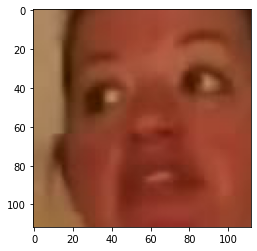

In [0]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

In [0]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [0]:
model = Model(2).cuda()
#model.load_state_dict(torch.load('./check.pt'))
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

In [0]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [0]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

[Epoch 1/20] [Batch 1285 / 1286] [Loss: 0.640068, Acc: 61.72%]Testing
[Batch 321 / 322]  [Loss: 0.554703, Acc: 71.62%]
Accuracy 71.61741835147745
[Epoch 2/20] [Batch 1285 / 1286] [Loss: 0.535636, Acc: 71.29%]Testing
[Batch 321 / 322]  [Loss: 0.451131, Acc: 78.77%]
Accuracy 78.77138413685847
[Epoch 3/20] [Batch 1285 / 1286] [Loss: 0.479677, Acc: 75.35%]Testing
[Batch 321 / 322]  [Loss: 0.424888, Acc: 81.10%]
Accuracy 81.10419906687403
[Epoch 4/20] [Batch 1285 / 1286] [Loss: 0.444594, Acc: 77.51%]Testing
[Batch 321 / 322]  [Loss: 0.462656, Acc: 79.86%]
Accuracy 79.86003110419907
[Epoch 5/20] [Batch 1285 / 1286] [Loss: 0.406597, Acc: 79.75%]Testing
[Batch 321 / 322]  [Loss: 0.440759, Acc: 83.13%]
Accuracy 83.12597200622083
[Epoch 6/20] [Batch 1285 / 1286] [Loss: 0.365328, Acc: 81.97%]Testing
[Batch 321 / 322]  [Loss: 0.431068, Acc: 82.66%]
Accuracy 82.65940902021772
[Epoch 7/20] [Batch 1285 / 1286] [Loss: 0.345672, Acc: 82.51%]Testing
[Batch 321 / 322]  [Loss: 0.463407, Acc: 83.20%]
Accur

ValueError: ignored

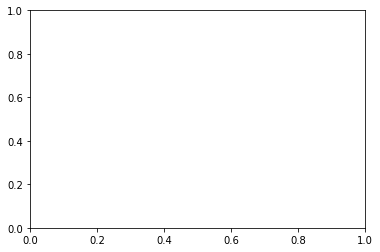

In [0]:
from sklearn.metrics import confusion_matrix
lr = 1e-5#0.001
num_epochs = 20
#num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

20


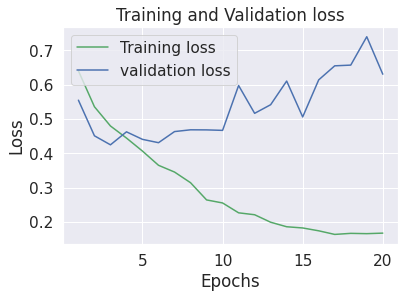

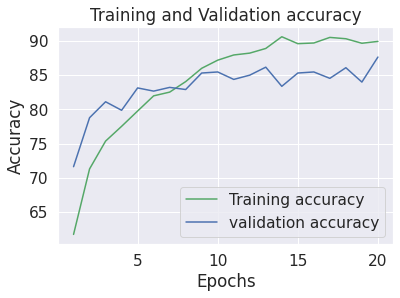

[[549  62]
 [ 97 578]]
True positive =  549
False positive =  62
False negative =  97
True negative =  578




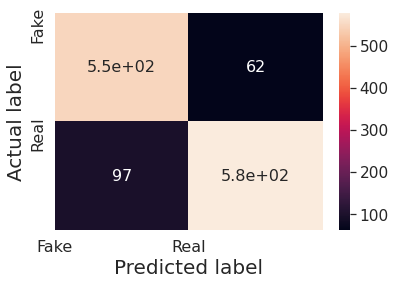

Calculated Accuracy 87.63608087091758


In [0]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

20


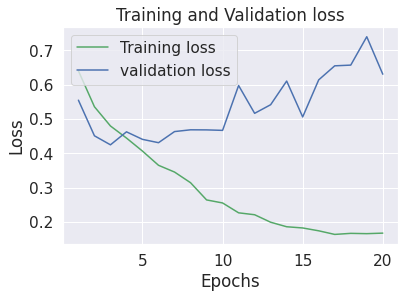

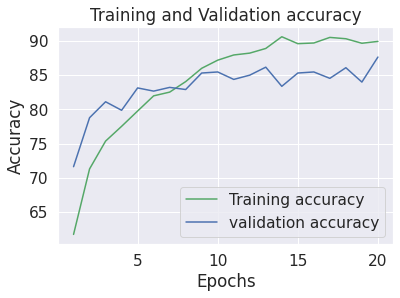

[[549  62]
 [ 97 578]]
True positive =  549
False positive =  62
False negative =  97
True negative =  578




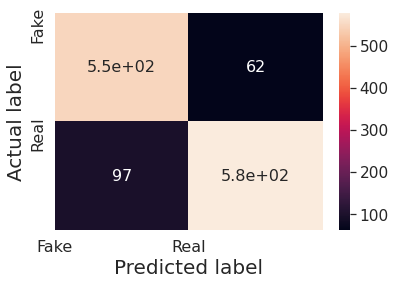

Calculated Accuracy 87.63608087091758


In [0]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
print()
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

In [0]:
for epoch in range(1,num_epochs+1):
    train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    print()
true,pred = test(epoch,model,valid_loader,criterion)
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

[Epoch 1/20] [Batch 1285 / 1286] [Loss: 0.153599, Acc: 90.22%]
[Epoch 2/20] [Batch 1285 / 1286] [Loss: 0.135459, Acc: 91.48%]
[Epoch 3/20] [Batch 1285 / 1286] [Loss: 0.157937, Acc: 90.39%]
[Epoch 4/20] [Batch 1285 / 1286] [Loss: 0.132656, Acc: 91.31%]
[Epoch 5/20] [Batch 1285 / 1286] [Loss: 0.135936, Acc: 91.01%]
[Epoch 6/20] [Batch 1285 / 1286] [Loss: 0.147132, Acc: 90.10%]
[Epoch 7/20] [Batch 1285 / 1286] [Loss: 0.134763, Acc: 90.88%]
[Epoch 8/20] [Batch 430 / 1286] [Loss: 0.142817, Acc: 90.60%]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-c8bd1af79355>", line 2, in <module>
    train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
  File "<ipython-input-9-67a5b6966f59>", line 18, in train_epoch
    acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
  File "<ipython-input-9-67a5b6966f59>", line 87, in calculate_accuracy
    n_correct_elems = correct.float().sum().item()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exceptio

KeyboardInterrupt: ignored

In [0]:
import pandas as pd
header_list = ["file","label"]

labels = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
unlabeled = []
for i in video_files:
  video_path = i
  temp_video = video_path.split('/')[-1]
  #print(temp_video)
  try:
    label = labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
  except:
    unlabeled.append(video_path.split('/')[-1])
print(unlabeled)


[]


Testing
[Batch 321 / 322]  [Loss: 0.438182, Acc: 90.90%]
Accuracy 90.90202177293935
[[584  41]
 [ 76 585]]
True positive =  584
False positive =  41
False negative =  76
True negative =  585




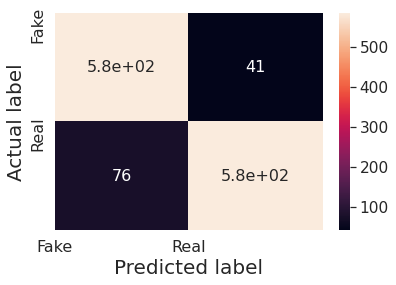

Calculated Accuracy 0.9090202177293935


In [0]:
num_epochs=1
for epoch in range(1,num_epochs+1):
    # train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    # print()
  true,pred = test(epoch,model,valid_loader,criterion)
  print(confusion_matrix(true,pred))
  print_confusion_matrix(true,pred)